# Fine-Pruning with a Sparse Trainer

> How to make sparse and fast models with a mix of structured and unstructured pruning

In this tutorial, we'll see how `nn_pruning` combines techniques from [movement pruning](https://arxiv.org/abs/2005.07683) and structured pruning to produce compact Transformers that can run inference faster than their dense counterparts, with little impact on accuracy. This tutorial is aimed at those who are familiar with the `transformers.Trainer` - if you're not, you can check out the [documentation](https://huggingface.co/transformers/main_classes/trainer.html?highlight=trainer#trainer) and `transformers` [examples](https://huggingface.co/transformers/examples.html#the-big-table-of-tasks) to see how it works. Let's get started! 

In [1]:
import os
os.environ['HF_ENDPOINT']='https://hf-mirror.com'
os.environ['CUDA_VISIBLE_DEVICES']='0'
import torch
import datasets
import transformers
datasets.logging.set_verbosity_error()
transformers.logging.set_verbosity_error()
print(f"Using transformers v{transformers.__version__} and datasets v{datasets.__version__} and torch v{torch.__version__}")

/home/cmyu/anaconda3/envs/tvm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using transformers v4.34.0 and datasets v3.0.1 and torch v2.0.1+cu117


## The dataset

To show `nn_pruning` in action, we'll use the [BoolQ dataset](https://arxiv.org/abs/1905.10044) which consists of naturally occurring yes/no questions concerning a passage of text. We can use the `datasets` library to load the dataset from the [Hugging Face Hub](https://huggingface.co/) as part of the [SuperGLUE benchmark](https://huggingface.co/datasets/super_glue):

In [2]:
from datasets import load_dataset

boolq = load_dataset("/state/partition/cmyu/super_glue", "boolq")
boolq

DatasetDict({
    train: Dataset({
        features: ['question', 'passage', 'idx', 'label'],
        num_rows: 9427
    })
    validation: Dataset({
        features: ['question', 'passage', 'idx', 'label'],
        num_rows: 3270
    })
    test: Dataset({
        features: ['question', 'passage', 'idx', 'label'],
        num_rows: 3245
    })
})

Let's take a look at one of the training examples:

In [3]:
boolq['train'][0]

{'question': 'do iran and afghanistan speak the same language',
 'passage': 'Persian language -- Persian (/ˈpɜːrʒən, -ʃən/), also known by its endonym Farsi (فارسی fārsi (fɒːɾˈsiː) ( listen)), is one of the Western Iranian languages within the Indo-Iranian branch of the Indo-European language family. It is primarily spoken in Iran, Afghanistan (officially known as Dari since 1958), and Tajikistan (officially known as Tajiki since the Soviet era), and some other regions which historically were Persianate societies and considered part of Greater Iran. It is written in the Persian alphabet, a modified variant of the Arabic script, which itself evolved from the Aramaic alphabet.',
 'idx': 0,
 'label': 1}

Here we can see that we're given a `question` about a `passage` of text, and the answer is given a value of 0 (false) / 1 (true) in the `label` field. To help the trainer automatically detect the labels, let's rename the column as follows: 

In [4]:
boolq.rename_column("label", "labels")

DatasetDict({
    train: Dataset({
        features: ['question', 'passage', 'idx', 'labels'],
        num_rows: 9427
    })
    validation: Dataset({
        features: ['question', 'passage', 'idx', 'labels'],
        num_rows: 3270
    })
    test: Dataset({
        features: ['question', 'passage', 'idx', 'labels'],
        num_rows: 3245
    })
})

## Tokenizing the question-answer pairs

Before we can fine-prune any models, the first thing we need to do is tokenize and encode the `question` and `passage` fields of each example. Currently, `nn_pruning` supports fine-pruning for BERT models so we'll use BERT-base and load up the tokenizer as follows:

In [5]:
from transformers import AutoTokenizer

bert_ckpt = "/state/partition/cmyu/models/t5-small"
tokenizer = AutoTokenizer.from_pretrained(bert_ckpt)

To tokenize our inputs, we'll pass the `question` and `passage` fields to our tokenizer and set `truncation="only_second"` to ensure that we only truncate the passages if the question-answer pair exceeds the maximum context length of 512 tokens. The following function does what we need and we can apply it to the whole dataset via the `DatasetDict.map` method:

In [6]:
def tokenize_and_encode(examples): 
    return tokenizer(examples['question'], examples['passage'], truncation="only_second")

boolq_enc = boolq.map(tokenize_and_encode, batched=True)

Using bos_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using bos_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using bos_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Map: 100%|██████████| 3245/3245 [00:00<00:00, 4149.25 examples/s]


## Creating a Sparse Trainer

The next thing to do is create a trainer that can handle the fine-pruning and evaluation steps for us. In `nn_pruning` this is done via the `sparse_trainer.SparseTrainer` [mixin class](https://realpython.com/inheritance-composition-python/#mixing-features-with-mixin-classes) that provides extra methods for `transformers.Trainer` to "patch" or sparsify pretrained models and implement the various pruning techniques discussed in the movement pruning paper.

To keep things simple, we'll override the `compute_loss` function to ignore knowledge distillation and just return the cross-entropy loss:

In [7]:
from transformers import Trainer
from nn_pruning.sparse_trainer import SparseTrainer

class PruningTrainer(SparseTrainer, Trainer):
    def __init__(self, sparse_args, *args, **kwargs):
        Trainer.__init__(self, *args, **kwargs)
        SparseTrainer.__init__(self, sparse_args)
        
    def compute_loss(self, model, inputs, return_outputs=False):
        """
        We override the default loss in SparseTrainer because it throws an 
        error when run without distillation
        """
        outputs = model(**inputs)

        # Save past state if it exists
        # TODO: this needs to be fixed and made cleaner later.
        if self.args.past_index >= 0:
            self._past = outputs[self.args.past_index]

        # We don't use .loss here since the model may return tuples instead of ModelOutput.
        loss = outputs["loss"] if isinstance(outputs, dict) else outputs[0]
        self.metrics["ce_loss"] += float(loss)
        self.loss_counter += 1
        return (loss, outputs) if return_outputs else loss

Note that `SparseTrainer` expects `sparse_args` in its `__init__` method. These arguments are analogous to  `transformers.TrainingArguments` and specify which pruning method is applied, whether knowledge distillation is activated, the associated hyperparameters, and more. Let's take a look at the defaults:

In [8]:
from nn_pruning.patch_coordinator import SparseTrainingArguments

sparse_args = SparseTrainingArguments()
sparse_args

SparseTrainingArguments(mask_scores_learning_rate=0.01, dense_pruning_method='topK', attention_pruning_method='topK', ampere_pruning_method='disabled', attention_output_with_dense=True, bias_mask=True, mask_init='constant', mask_scale=0.0, dense_block_rows=1, dense_block_cols=1, attention_block_rows=1, attention_block_cols=1, initial_threshold=1.0, final_threshold=0.5, initial_warmup=1, final_warmup=2, initial_ampere_temperature=0.0, final_ampere_temperature=20.0, regularization='disabled', regularization_final_lambda=0.0, attention_lambda=1.0, dense_lambda=1.0, decoder_attention_lambda=None, decoder_dense_lambda=None, distil_teacher_name_or_path=None, distil_alpha_ce=0.5, distil_alpha_teacher=0.5, distil_temperature=2.0, final_finetune=False, layer_norm_patch=False, layer_norm_patch_steps=50000, layer_norm_patch_start_delta=0.99, gelu_patch=False, gelu_patch_steps=50000, linear_min_parameters=0.005, rewind_model_name_or_path=None, eval_with_current_patch_params=False, qat=False, qconf

The main hyperparameters to tweak for fine-pruning are:

* `dense_pruning_method` / `attention_pruning_method`: determines how the matrix of mask scores are calculated for the dense/attention layers. Can take one of the following values: 
    * `l0`: $L_0$ regularization
    * `magnitude`: magnitude pruning
    * `topK`: Movement pruning
    * `sigmoied_threshold`: soft movement pruning
* `initial_threshold`: the initial value of the masking threshold for scheduling. Set this to 1 when using `topK` (initial density) or 0 when using `sigmoied_threshold` (cutoff)
* `final_threshold`: the final value of the masking threshold. When using `topK`, this is the final density. With `sigmoied_threshold`, a good choice is 0.1 
* `initial_warmup`: runs `initial_warmup` * `warmup_steps` steps of threshold warm-up during which threshold stays at its `initial_threshold` value (sparsity schedule)
* `final_warmup`: runs `final_warmup` * `warmup_steps` steps of threshold cool-down during which threshold stays at its final_threshold value (sparsity schedule)

For our example, let's use `topK` movement pruning and remove 50% of the weights in the encoder. We'll apply a form of "hybrid pruning" by performing block pruning on the attention layers and adding the `1d_alt` argument for the dense layers, which prunes alternating rows and columns and produces better results:

In [9]:
hyperparams = {
    "dense_pruning_method": "topK", 
    "attention_pruning_method": "topK", 
    "initial_threshold": 1.0, 
    "final_threshold": 0.75, 
    "initial_warmup": 1,
    "final_warmup": 3,
    "attention_block_rows":1,
    "attention_block_cols":32,
    "dense_block_rows":1,
    "dense_block_cols":32,
    "attention_output_with_dense": 0
}

for k,v in hyperparams.items():
    if hasattr(sparse_args, k):
        setattr(sparse_args, k, v)
    else:
        print(f"sparse_args does not have argument {k}")

In addition to the pruning hyperparameters, we also need the usual training parameters like learning rate, batch size and so on. These can be configured using `transformers.TrainingArguments` as follows:

In [10]:
from transformers import TrainingArguments

batch_size = 16
learning_rate = 2e-5
num_train_epochs = 6
logging_steps = len(boolq_enc["train"]) // batch_size
# warmup for 10% of training steps
warmup_steps = logging_steps * num_train_epochs * 0.1

args = TrainingArguments(
    output_dir="checkpoints",
    evaluation_strategy="epoch",
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=learning_rate,
    weight_decay=0.01,
    logging_steps=logging_steps,
    disable_tqdm=False,
    report_to=None
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


> Tip: a key ingredient for getting good results with movement pruning is to prune the model slowly by training for several epochs and including some amount of linear warmup (6-10% of the total steps is a good heuristic).

## Patching a Dense Model

To enable movement pruning, we need masked versions of BERT-base that can compute the adaptive mask in the forward pass. The way this is done in `nn_pruning` is via the `ModelPatchingCoordinator` class:

In [11]:
import torch 
from transformers import AutoModelForSequenceClassification
from nn_pruning.patch_coordinator import ModelPatchingCoordinator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mpc = ModelPatchingCoordinator(
    sparse_args=sparse_args, 
    device=device, 
    cache_dir="checkpoints", 
    logit_names="logits", 
    model_name_or_path=bert_ckpt,
    teacher_constructor=None)

This class has several methods that control how pruning is applied during training and how to convert a pruned model into a format that is compatible for runnning inference with the `transformers` API. The first thing we need to do is "patch" our dense model which can be achieved with the `ModelPatchingCoordinator.patch_model` function as follows:

In [12]:
bert_model = AutoModelForSequenceClassification.from_pretrained(bert_ckpt).to(device)
# print(mpc.get_patchable_layers(bert_model))
# print(mpc.patch_model)
mpc.patch_model(bert_model)
# bert_model.save_pretrained("models/patched")

[{'pattern': '(en|de)coder\\.block\\.[0-9]+\\.layer\\.[0-9]+\\.SelfAttention\\.q', 'patch_info': {'patcher': <nn_pruning.modules.masked_nn.LinearPruningModulePatcher object at 0x7fe00cd4e130>}}, {'pattern': '(en|de)coder\\.block\\.[0-9]+\\.layer\\.[0-9]+\\.SelfAttention\\.k', 'patch_info': {'patcher': <nn_pruning.modules.masked_nn.LinearPruningModulePatcher object at 0x7fe00cd4e130>}}, {'pattern': '(en|de)coder\\.block\\.[0-9]+\\.layer\\.[0-9]+\\.SelfAttention\\.v', 'patch_info': {'patcher': <nn_pruning.modules.masked_nn.LinearPruningModulePatcher object at 0x7fe00cd4e130>}}, {'pattern': '(en|de)coder\\.block\\.[0-9]+\\.layer\\.[0-9]+\\.SelfAttention\\.o', 'patch_info': {'patcher': <nn_pruning.modules.masked_nn.LinearPruningModulePatcher object at 0x7fe15bf4da60>}}, {'pattern': '(en|de)coder\\.block\\.[0-9]+\\.layer\\.[0-9]+\\.EncDecAttention\\.q', 'patch_info': {'patcher': <nn_pruning.modules.masked_nn.LinearPruningModulePatcher object at 0x7fe00cd4e130>}}, {'pattern': '(en|de)coder\\

In [13]:
bert_model

T5ForSequenceClassification(
  (transformer): T5Model(
    (shared): Embedding(32128, 512)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32128, 512)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=512, out_features=512, bias=False)
                (k): Linear(in_features=512, out_features=512, bias=False)
                (v): Linear(in_features=512, out_features=512, bias=False)
                (o): Linear(in_features=512, out_features=512, bias=False)
                (relative_attention_bias): Embedding(32, 8)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
                (wi): Linear(in_features=512, out_features=2048, bias=False)
                (wo): Linear(in_featu

## Fine-pruning

We almost have all the ingredients needed to fine-prune our model! The only thing missing is the `compute_metrics` function for our trainer, so let's load the `accuracy` metric from `datasets` to measure the performance of our model:

In [14]:
import numpy as np
# from datasets import load_metric
from evaluate import load

accuracy_score = load('accuracy')

def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

The last thing to do is instantiate our trainer

In [15]:
trainer = PruningTrainer(
    sparse_args=sparse_args,
    args=args,
    model=bert_model,
    train_dataset=boolq_enc["train"],
    eval_dataset=boolq_enc["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    # load_best_model_at_end=True,
    # metric_for_best_model="accuracy"
)

/home/cmyu/anaconda3/envs/tvm/lib/python3.8/site-packages/accelerate/accelerator.py:451: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


specify the patch coordinator during training

In [16]:
trainer.set_patch_coordinator(mpc)

and fine-prune:

In [17]:
trainer.train();

/home/cmyu/anaconda3/envs/tvm/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


OutOfMemoryError: CUDA out of memory. Tried to allocate 50.00 MiB (GPU 0; 47.40 GiB total capacity; 1.39 GiB already allocated; 35.69 MiB free; 1.40 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

We can see that the model starts to overfit a bit on the last epoch. Nevertheless, our 71.6% accuracy on the fifth epoch is not far from the 76.5% accuracy that an unpruned BERT-base achieves on BoolQ (this value is taken Table 2 of the [SustaiNLP 2020 benchmark](https://www.aclweb.org/anthology/2020.sustainlp-1.24/)). Since this took a while to train, let's save it for later use:

In [17]:
output_model_path = "models/bert-base-uncased-finepruned-boolq"
trainer.save_model(output_model_path)

## Optimising for inference

Once a model has been fine-pruned, the weights that are masked during the forward pass can be set to zero and pruned once for all (which reduces the amount of information to store). This is achieved by applying the `ModelPatchingCoordinator.compile_model` function which will transform the model in-place and make it compatible with `transformers`:

In [19]:
mpc.compile_model(trainer.model)

AttributeError: 'T5Attention' object has no attribute 'num_heads'

We can also visualise how the dense layers are pruned in alternating rows and columns, while the attention layers are pruned in a blockwise fashion: 

bert.encoder.layer.11.intermediate.dense.weight


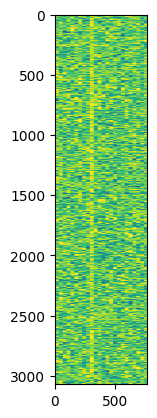

bert.encoder.layer.11.attention.output.dense.weight


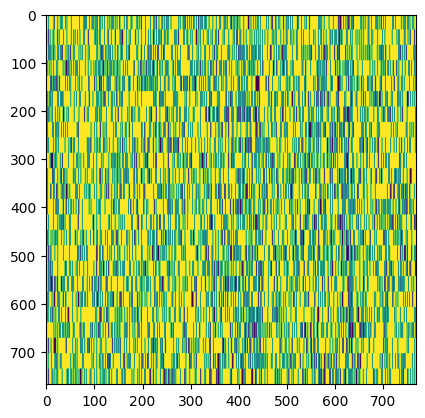

In [19]:
from matplotlib import pyplot as plt

parameters = dict(trainer.model.named_parameters())
param_names = ["bert.encoder.layer.11.intermediate.dense.weight",
               "bert.encoder.layer.11.attention.output.dense.weight"]

for param_name in param_names:          
    w = parameters[param_name]
    print(param_name)

    plt.imshow((w != 0).detach().cpu())
    plt.show()

However, this alone won't give us any speed-up during inference because matrix multiplication does not get faster just because more values are zero. To take care of this, `nn_pruning` provides an `optimize_model` function that will cleverly remove the zeroes from the model and produce a pruned model that has fewer parameters (and thus faster for inference):

In [20]:
from nn_pruning.inference_model_patcher import optimize_model

prunebert_model = optimize_model(trainer.model, "dense")

removed heads 0, total_heads=144, percentage removed=0.0
bert.encoder.layer.0.intermediate.dense, sparsity = 0.00
bert.encoder.layer.0.output.dense, sparsity = 0.00
bert.encoder.layer.1.intermediate.dense, sparsity = 0.00
bert.encoder.layer.1.output.dense, sparsity = 0.00
bert.encoder.layer.2.intermediate.dense, sparsity = 0.00
bert.encoder.layer.2.output.dense, sparsity = 0.00
bert.encoder.layer.3.intermediate.dense, sparsity = 0.00
bert.encoder.layer.3.output.dense, sparsity = 0.00
bert.encoder.layer.4.intermediate.dense, sparsity = 0.00
bert.encoder.layer.4.output.dense, sparsity = 0.00
bert.encoder.layer.5.intermediate.dense, sparsity = 0.00
bert.encoder.layer.5.output.dense, sparsity = 0.00
bert.encoder.layer.6.intermediate.dense, sparsity = 0.00
bert.encoder.layer.6.output.dense, sparsity = 0.00
bert.encoder.layer.7.intermediate.dense, sparsity = 0.00
bert.encoder.layer.7.output.dense, sparsity = 0.00
bert.encoder.layer.8.intermediate.dense, sparsity = 0.00
bert.encoder.layer.8.o

We can also see what fraction of total parameters remain in our pruned model:

In [21]:
prunebert_model.num_parameters() / bert_model.num_parameters()

1.0

To see what kind of inference gains our pruned model provides, let's write a simple function that computes the average latency from several runs involving a fixed question-passage pair:

In [22]:
from time import perf_counter

def compute_latencies(model,
                      question="Is Saving Private Ryan based on a book?",
                      passage="""In 1994, Robert Rodat wrote the script for the film. Rodat’s script was submitted to 
                      producer Mark Gordon, who liked it and in turn passed it along to Spielberg to direct. The film is 
                      loosely based on the World War II life stories of the Niland brothers. A shooting date was set for 
                      June 27, 1997"""):
    inputs = tokenizer(question, passage, truncation="only_second", return_tensors="pt")
    latencies = []
    
    # Warmup
    for _ in range(10):
        _ = model(**inputs)
        
    for _ in range(100):
        start_time = perf_counter()
        _ = model(**inputs)
        latency = perf_counter() - start_time 
        latencies.append(latency)
        # Compute run statistics
        time_avg_ms = 1000 * np.mean(latencies)
        time_std_ms = 1000 * np.std(latencies) 
    print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}") 
    return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

Let's use this function to calculate the latency of our pruned model:

In [23]:
latencies = {}
latencies["prunebert"] = compute_latencies(prunebert_model.to("cpu"))

Average latency (ms) - 26.20 +\- 46.31


Similarly we can calculate the latency of a fine-tuned model that is available on the Hugging Face Hub:

In [ ]:
bert_unpruned = AutoModelForSequenceClassification.from_pretrained("lewtun/bert-base-uncased-finetuned-boolq").to("cpu")

latencies["bert-base"] = compute_latencies(bert_unpruned.to("cpu"))

/home/cmyu/anaconda3/envs/tvm/lib/python3.8/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


We can compare the two models visually by loading our `latencies` dictionary as a Pandas DataFrame:

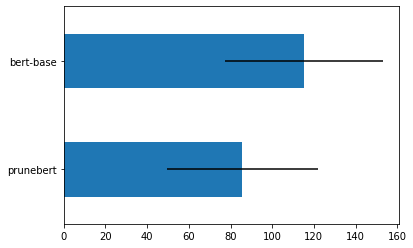

In [ ]:
import pandas as pd

df = pd.DataFrame.from_dict(latencies, orient="index")
df.plot(y='time_avg_ms', kind="barh", legend=False, xerr="time_std_ms");

These latencies will depend on the type of hardware you are running inference on, but what's important here is the _relative_ difference between the models. In this case we see that by removing half of the encoder's weights, we've managed to speedup our model by a factor of 1.35x - more gains could be had by removing even more weights.